# Create a Projection based on people

This notebook creates a projection based on People's names found in the entities. This should be a small showcase that can also serve later to do a projeciton of locations or other based on other entities

In [ ]:
# pip install umap-learn seaborn

In [1]:
from emv.db.dao import DataAccessObject
from sqlalchemy.sql import text
import pandas as pd
import json
from collections import Counter

## Selecting people from the entities

We will start by selecting the people from the database. The spacy library was used to identify the entities and we only need to filter them by the type "PER".

In [2]:
query = text("""SELECT * FROM feature WHERE feature_type = 'transcript+ner';""")
df = pd.DataFrame(DataAccessObject().fetch_all(query))

In [3]:
# This could only be the PER type but the code has been kept universal here
all_entities = {"LOC": [], "PER": [], "ORG": [], "MISC": []}

for i, row in df.iterrows():
    try:
        for ent in row['data']['entities']:
            all_entities[ent[1]].append(ent[0])  #.lower())
    except KeyError:
        pass

for key in all_entities:
    all_entities[key] = Counter(all_entities[key])

In [4]:
# get all entities that have a count of 5 or more
persons = {k: v for k, v in all_entities['PER'].items() if v >= 10 and " " in k}
persons = set(persons.keys())

In [5]:
per = df.copy()

In [6]:
# Before we can do other filtering, we need to just take the rows of the df that has entities in data
df_per = per[per['data'].apply(lambda x: 'entities' in x)]

In [7]:
# Filter the dataframe to only include rows where the person is in the set of persons
df_per = df_per[df_per['data'].apply(lambda x: any([ent[0] in persons for ent in x['entities']]))]

In [8]:
df_per = df_per[df_per['embedding_size'] == 1024]

In [2]:
# Dimensionality reduction and clustering
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

In [10]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In [11]:
df_per['embedding'] = df_per['embedding_1024'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split(',')]))


In [12]:
scaled_data = StandardScaler().fit_transform(np.array(df_per.embedding.values.tolist()))

In [13]:
import umap

reducer = umap.UMAP()
embedding = reducer.fit_transform(scaled_data)

In [15]:
with open("persons.json", "w") as f:
    json.dump(list(persons), f)

In [14]:
with open("persons_categorized.json", "r") as f:
    full_categorized_list = json.load(f)

In [15]:
name_mapping = {line["Name"]: line["Category"] for line in full_categorized_list}

In [16]:
# Assign name mapping to the df_per dataframe, but assign at most one category
# df_per['category'] = df_per['data'].apply(lambda x: [name_mapping[ent[0]] for ent in x['entities'] if ent[0] in name_mapping])
df_per['category'] = df_per['data'].apply(lambda x: [name_mapping[ent[0]] for ent in x['entities'] if ent[0] in name_mapping][0] if len([name_mapping[ent[0]] for ent in x['entities'] if ent[0] in name_mapping]) > 0 else None)

In [17]:
# replace isna with fillna categories
df_per['category'] = df_per['category'].fillna("Unknown")

In [18]:
category_map = {
    "Sports": 0, 
    "Politics": 1, 
    "Fictional and Symbolic Figure": 2,
    "Activism and Humanitarian": 3,
    "Art and Literature": 4,
    "Military and National Leaders": 5,
    "Religious and Spiritual Leaders": 6,
    "Science and Exploration": 7,
    "Business and Industry": 8,
    'Music and Entertainment': 9,
    'Unknown': 10
}


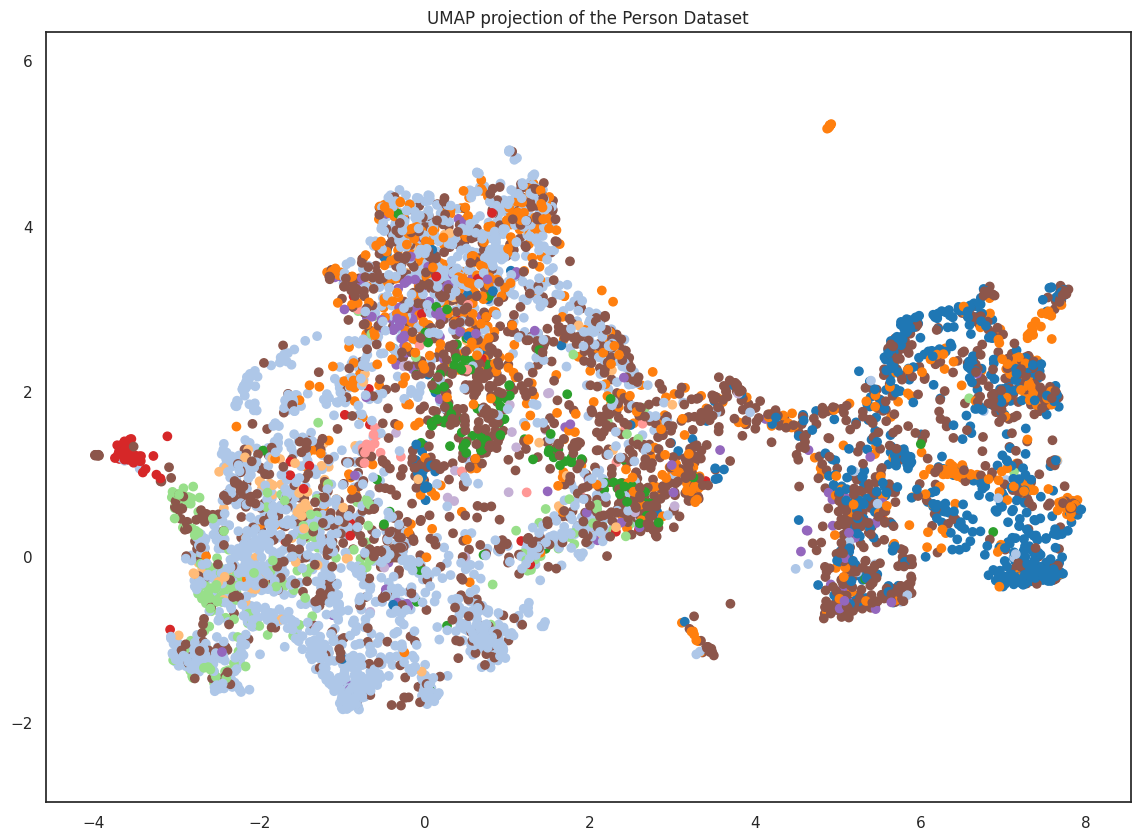

In [19]:

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette("tab20")[x] for x in df_per.category.map(category_map)])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Person Dataset', fontsize=12);

In [ ]:
# ! pip install bokeh

In [20]:
from bokeh.plotting import figure, show, output_notebook
# Do the same visulization, but with bokeh so that we can hover over the points to see the names and the categories
from bokeh.models import HoverTool, ColumnDataSource
# import palette with at least 20 colors
from bokeh.palettes import Category20
output_notebook()

Loading BokehJS ...

In [ ]:

source = ColumnDataSource(data=dict(
    x=embedding[:, 0],
    y=embedding[:, 1],
    categories=df_per['category'],
    fill_color=[Category20[11][category_map[x]] for x in df_per.category],
    names=[ent[0] for ent in df_per['data'].apply(lambda x: [ent for ent in x['entities'] if ent[0] in persons])]
))

hover = HoverTool(tooltips=[
    ("Name", "@names"),
    ("Category", "@categories")
])

p = figure(width=800, height=800, tools=[hover, 'pan', 'wheel_zoom', 'box_zoom', 'reset', 'save'])

p.circle('x', 'y', fill_color="fill_color", size=5, source=source) #, fill_color=[Category20[11][category_map[x]] for x in df_per.category])

show(p)


In [22]:
# Run umap for a 3D plot
reducer = umap.UMAP(n_components=3)
embedding = reducer.fit_transform(scaled_data)

In [21]:
# ! pip install plotly

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(
    x=embedding[:, 0],
    y=embedding[:, 1],
    z=embedding[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=[sns.color_palette("tab20")[x] for x in df_per.category.map(category_map)],
        opacity=0.8
    )
)])

# Hovertext
fig.update_traces(
    hoverinfo='text',
    text=[f"Name: {ent[0]}<br>Category: {cat}" for ent, cat in zip(df_per['data'].apply(lambda x: [ent for ent in x['entities'] if ent[0] in persons]), df_per.category)]
)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.show()


In [25]:
df_per.shape

(5177, 14)

## Final step

Create the Projection in the database

In [3]:
from emv.api.models import Projection, MapProjectionFeatureCreate
from emv.db.queries import create_projection, create_map_projection_feature, get_media_by_id, get_all_projections
from emv.db.dao import DataAccessObject
from sqlalchemy.sql import text

In [28]:
projections = get_all_projections()

In [31]:
projection_id = projections[0]['projection_id']

In [29]:
total_tiles = len(df_per)
atlas_width = 1024
max_tile_size = 128
max_tiles_per_atlas = (atlas_width // max_tile_size) ** 2
atlas_count = int(total_tiles / max_tiles_per_atlas) + 1

projection = Projection(
    projection_name="RTS Persons",
    version="0.0.1",
    library_id=4,
    model_name="random",
    model_params={},
    data={},
    dimension=3,
    atlas_folder_path="",
    atlas_width=atlas_width,
    tile_size=max_tile_size,
    atlas_count=atlas_count,
    total_tiles=total_tiles,
    tiles_per_atlas=max_tiles_per_atlas,
)

In [173]:
# projection_id = create_projection(projection)['projection_id']

In [4]:
from emv.storage.storage import get_storage_client
from emv.io.media import upload_media_files, create_square_atlases
from PIL import Image
from io import BytesIO

In [5]:
from tqdm import tqdm_notebook as tqdm

In [34]:
images = []

for i, row in tqdm(df_per.iterrows()):
    query = text("""SELECT * FROM media WHERE parent_id = :parent_id;""")
    try:
        media = DataAccessObject().fetch_all(query, {"parent_id": row.media_id})[0]
    except IndexError:
        pass
    images.append(get_storage_client().get_bytes("rts", media['media_path']))

/tmp/ipykernel_2379526/548515357.py:3: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



0it [00:00, ?it/s]

In [8]:
# BUGFIX: GET atlases again as the resolution was not correct (eliminate the borders)
query = text("""SELECT * FROM projection""")
DataAccessObject().fetch_all(query)

[{'projection_id': 1, 'version': '0.0.1', 'library_id': 4, 'created_at': datetime.datetime(2024, 2, 20, 15, 2, 39, 475167), 'model_name': 'random', 'model_params': {}, 'data': {}, 'dimension': 3, 'atlas_folder_path': '', 'atlas_width': 1024, 'tile_size': 128, 'atlas_count': 74, 'total_tiles': 4676, 'tiles_per_atlas': 64}]

In [6]:
# BUGFIX: GET atlases again as the resolution was not correct (eliminate the borders)
images = {}

query = text("""SELECT * FROM map_projection_feature WHERE projection_id=1""")
mpfs = DataAccessObject().fetch_all(query)
media_objects = {}
for row in mpfs:
    query = text("""SELECT * FROM media WHERE parent_id = :parent_id;""")
    try:
        media_objects[row['map_projection_feature_id']] = DataAccessObject().fetch_all(query, {"parent_id": row['media_id']})[1]
    except IndexError:
        try:
            media_objects[row['map_projection_feature_id']] = DataAccessObject().fetch_all(query, {"parent_id": row['media_id']})[0]
        except IndexError:
            media_objects[row['map_projection_feature_id']] = None
    if media_objects[row['map_projection_feature_id']]:
        images[row['map_projection_feature_id']] =  get_storage_client().get_bytes("rts", media_objects[row['map_projection_feature_id']]['media_path'])

In [7]:
media_objects[row['map_projection_feature_id']]

{'media_id': 'rts-ZB010150-M011-01', 'media_path': 'images/ZB010150/512px/ZB010150-M011-01.jpg', 'original_path': 'images/ZB010150/512px/ZB010150-M011-01.jpg', 'original_id': 'ZB010150', 'created_at': datetime.datetime(2024, 2, 19, 8, 51, 55, 780790), 'media_type': 'image', 'media_info': {}, 'sub_type': 'screenshot', 'size': -1, 'metadata': None, 'library_id': 4, 'hash': '17cb9a464c08456c89241a743aae2387', 'parent_id': 'rts-ZB010150-M011', 'start_ts': 349.36, 'end_ts': 367.4, 'start_frame': 8734, 'end_frame': 9185, 'frame_rate': -1.0}

In [42]:
len(media_objects), len(images)

(5177, 5176)

In [13]:
img_bytes = []
for key in images:
    img = Image.open(BytesIO(images[key]))
    # img_bytes.append(img.tobytes())
    img_bytes.append(img)

In [9]:
query = text("""SELECT * FROM media WHERE parent_id = :parent_id;""")
DataAccessObject().fetch_all(query, {"parent_id": 'rts-ZB184963-M061'})

[{'media_id': 'rts-ZB184963-M061-00', 'media_path': 'images/ZB184963/512px/ZB184963-M061-00.jpg', 'original_path': 'images/ZB184963/512px/ZB184963-M061-00.jpg', 'original_id': 'ZB184963', 'created_at': datetime.datetime(2024, 2, 19, 12, 41, 21, 177677), 'media_type': 'image', 'media_info': {}, 'sub_type': 'screenshot', 'size': -1, 'metadata': None, 'library_id': 4, 'hash': '29dc747fe0048a923b437b6d01fe1bbd', 'parent_id': 'rts-ZB184963-M061', 'start_ts': 2730.92, 'end_ts': 2744.88, 'start_frame': 68273, 'end_frame': 68622, 'frame_rate': -1.0},
 {'media_id': 'rts-ZB184963-M061-01', 'media_path': 'images/ZB184963/512px/ZB184963-M061-01.jpg', 'original_path': 'images/ZB184963/512px/ZB184963-M061-01.jpg', 'original_id': 'ZB184963', 'created_at': datetime.datetime(2024, 2, 19, 12, 41, 21, 512572), 'media_type': 'image', 'media_info': {}, 'sub_type': 'screenshot', 'size': -1, 'metadata': None, 'library_id': 4, 'hash': '3315004c2b3c32eba174b599aec9f5af', 'parent_id': 'rts-ZB184963-M061', 'star

In [14]:
square_atlases = create_square_atlases("atlas_rts_persons", 1, img_bytes, width=4096, max_tile_size=512, no_border=True)

In [24]:
# get all atlases
query = text("""SELECT * FROM atlas""")
atlases = DataAccessObject().fetch_all(query)

In [26]:
sorted(atlases, key=lambda x: x['atlas_id'])[:5]

[{'atlas_id': 352, 'projection_id': 1, 'atlas_order': 0, 'atlas_path': 'atlas/atlas_rts_persons_0.jpg', 'atlas_size': '[4096,4096]', 'tile_size': '[512,512]', 'tile_count': 64, 'rows': 8, 'cols': 8, 'tiles_per_atlas': 64},
 {'atlas_id': 353, 'projection_id': 1, 'atlas_order': 1, 'atlas_path': 'atlas/atlas_rts_persons_1.jpg', 'atlas_size': '[4096,4096]', 'tile_size': '[512,512]', 'tile_count': 64, 'rows': 8, 'cols': 8, 'tiles_per_atlas': 64},
 {'atlas_id': 354, 'projection_id': 1, 'atlas_order': 2, 'atlas_path': 'atlas/atlas_rts_persons_2.jpg', 'atlas_size': '[4096,4096]', 'tile_size': '[512,512]', 'tile_count': 64, 'rows': 8, 'cols': 8, 'tiles_per_atlas': 64},
 {'atlas_id': 355, 'projection_id': 1, 'atlas_order': 3, 'atlas_path': 'atlas/atlas_rts_persons_3.jpg', 'atlas_size': '[4096,4096]', 'tile_size': '[512,512]', 'tile_count': 64, 'rows': 8, 'cols': 8, 'tiles_per_atlas': 64},
 {'atlas_id': 356, 'projection_id': 1, 'atlas_order': 4, 'atlas_path': 'atlas/atlas_rts_persons_4.jpg', 'atl

In [37]:
# count atlas entries
query = text("""SELECT COUNT(*) FROM atlas""")
DataAccessObject().fetch_all(query)

[{'count': 81}]

In [21]:
# remove every atlas with atlas id < 352
query = text("""DELETE FROM atlas WHERE atlas_id < 352""")
DataAccessObject().execute_query(query)

In [39]:
query = text("""SELECT * FROM projection""")
projection = DataAccessObject().fetch_all(query)
# print the projection dictionary nicely
for key in projection[0]:
    print(f"{key}: {projection[0][key]}")

projection_id: 1
version: 0.0.1
library_id: 4
created_at: 2024-02-20 15:02:39.475167
model_name: random
model_params: {}
data: {}
dimension: 3
atlas_folder_path: 
atlas_width: 4096
tile_size: 512
atlas_count: 81
total_tiles: 4676
tiles_per_atlas: 64


In [43]:
# update projection atlas width to 4096, tile size to 512
query = text("""UPDATE projection SET atlas_width = 4096, tile_size = 512, atlas_count = 81, total_tiles = 5176 WHERE projection_id = 1""")
DataAccessObject().execute_query(query)

In [10]:
img_bytes = [Image.open(BytesIO(img)) for img in images]

TypeError: a bytes-like object is required, not 'int'

In [68]:
square_atlases = create_square_atlases("atlas_rts_persons", projection_id, img_bytes, width=4096, max_tile_size=512, no_border=True)

In [59]:
feature_ids = list(df_per.feature_id)
len(feature_ids)

5177

In [61]:
for i in range(len(embedding)):
    create_map_projection_feature(MapProjectionFeatureCreate(
        projection_id=projection_id,
        media_id=row.media_id,
        atlas_order=i // max_tiles_per_atlas,
        index_in_atlas=i % max_tiles_per_atlas,
        coordinates=[embedding[i, 0], embedding[i, 1], embedding[i, 2]],
        feature_id=feature_ids[i]
    ))

In [57]:
for i, row in df_per.iterrows():
    ...
i

241132

In [41]:
len(df_per) / len(square_atlases)

63.91358024691358

In [7]:
from emv.db.queries import create_atlas, create_media, create_projection
from emv.storage.storage import get_storage_client
from emv.api.models import Atlas, Media, Projection

In [67]:
for i in range(1, 64):
    atlas = Atlas(
        projection_id=projection_id,
        atlas_order=i,
        atlas_path=f'atlas/atlas_rts_persons_{i}.jpg',
        atlas_size=[1024,1024],
        tile_size=[128,128],
        tile_count=64,
        rows=8,
        cols=8,
        tiles_per_atlas=64,
    )
    r = create_atlas(atlas)
    print(r)

{'projection_id': 1, 'atlas_order': 1, 'atlas_path': 'atlas/atlas_rts_persons_1.jpg', 'atlas_size': [1024.0, 1024.0], 'tile_size': [128.0, 128.0], 'tile_count': 64, 'rows': 8, 'cols': 8, 'tiles_per_atlas': 64, 'atlas_id': 208}
{'projection_id': 1, 'atlas_order': 2, 'atlas_path': 'atlas/atlas_rts_persons_2.jpg', 'atlas_size': [1024.0, 1024.0], 'tile_size': [128.0, 128.0], 'tile_count': 64, 'rows': 8, 'cols': 8, 'tiles_per_atlas': 64, 'atlas_id': 209}
{'projection_id': 1, 'atlas_order': 3, 'atlas_path': 'atlas/atlas_rts_persons_3.jpg', 'atlas_size': [1024.0, 1024.0], 'tile_size': [128.0, 128.0], 'tile_count': 64, 'rows': 8, 'cols': 8, 'tiles_per_atlas': 64, 'atlas_id': 210}
{'projection_id': 1, 'atlas_order': 4, 'atlas_path': 'atlas/atlas_rts_persons_4.jpg', 'atlas_size': [1024.0, 1024.0], 'tile_size': [128.0, 128.0], 'tile_count': 64, 'rows': 8, 'cols': 8, 'tiles_per_atlas': 64, 'atlas_id': 211}
{'projection_id': 1, 'atlas_order': 5, 'atlas_path': 'atlas/atlas_rts_persons_5.jpg', 'atlas

In [74]:
for i in range(len(embedding)):
    print(df_per.iloc[i]['data'], df_per.iloc[i]['media_id'])

{'entities': [['Boris Yeltsin', 'PER']], 'transcript': 'Boris Yeltsin a beau tenter de séduire ses sujets, sa crédibilité est au plus bas. Seuls 5% des russes lui font encore confiance.'} rts-ZF002066-M052
{'entities': [['Philippe', 'PER'], ['Donald Trump', 'PER']], 'transcript': "– Philippe, merci, rendez-vous demain, second volet de cet anniversaire, reportage cette fois sur les adversaires de Donald Trump. La France en fait un instrument de sa politique, le Louvre à Abu Dhabi a été conçu par Jean Nouvel, inauguré par Emmanuel Macron, c'est une performance technique avec un dôme gigantesque, c'est aussi une forme de vœu, de bonne entente entre l'Orient et l'Occident. Michel Verret."} rts-ZT034550-M068
{'entities': [['Donald Trump', 'PER'], ['Hillsdale', 'LOC'], ['Michigan', 'LOC'], ['État', 'LOC']], 'transcript': "Ce périple sur les terres de Donald Trump se termine à Hillsdale, au Michigan, l'État qui lui a offert la victoire de justesse pour 10 000 voix. Un an après, ses partisans 